<a href="https://colab.research.google.com/github/Untick/InspectrumClinic_RecSys/blob/main/Zemlyakov_Serj/Int_1_%D0%9F%D1%80%D0%BE%D1%84%D0%BF%D0%B0%D1%82%D0%BE%D0%BB%D0%BE%D0%B3_2_00.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Работа с массивами данных
import numpy as np 

# Работа с табличными данными
import pandas as pd

import string

import tensorflow as tf

# Функции-утилиты для работы с категориальными данными
from tensorflow.keras import utils

# Класс для конструирования последовательной модели нейронной сети
from tensorflow.keras.models import Sequential, Model

# Основные слои
from tensorflow.keras.layers import Dense, Dropout, SpatialDropout1D, BatchNormalization, Embedding, Flatten, Activation, Input, concatenate
from tensorflow.keras.layers import SimpleRNN, GRU, LSTM, Bidirectional, Conv1D, MaxPooling1D, GlobalMaxPooling1D

# Оптимизаторы
from tensorflow.keras.optimizers import Adam, Adadelta, SGD, Adagrad, RMSprop

# Токенизатор для преобразования текстов в последовательности
from tensorflow.keras.preprocessing.text import Tokenizer

# Матрица ошибок классификатора
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Масштабирование данных
from sklearn.preprocessing import StandardScaler

# Загрузка датасетов из облака google
import gdown

# Регулярные выражения
import re

import random

#Для работы с файлами 
import os 

from google.colab import files

# Отрисовка графиков
import matplotlib.pyplot as plt

# Метрики для расчета ошибок
from sklearn.metrics import mean_squared_error, mean_absolute_error

from sklearn.model_selection import train_test_split

!pip install tensorflow-addons

import tensorflow_addons as tfa

from tensorflow_addons.metrics import F1Score

%matplotlib inline



Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 591.0/591.0 kB 9.1 MB/s eta 0:00:00


/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [ ]:
# Mount Google Drive
import os
from google.colab import drive

drive.mount('/content/drive')
!pwd
!ls



In [2]:
# Загрузка базы данных заказчика, предварительно сохарненной в формате *.csv
import pandas as pd
df = pd.read_csv('/content/drive/MyDrive/internsheep1/profpat_1.csv')


<ipython-input-2-7a3e14bf7a04>:3: DtypeWarning: Columns (24,25,26,43,44,45,46,47,48,54,55,56,57,58,59,60,61,62,63,64,65,77,78,79,81,84,85,86,87,88,89,90,91,92,108,109,112,113,120,121,122,123,124,125,126,127,162,163,164,168,169,170,171,172,173,174,195,196,201,202,203,204,205,206,207,208,221,222,223,228,229,230,252,253,258,259,260,261,262,263,264,265,266,267,270,271,272,273,276,277,278,279,282,283,284,285,286,287,293,294,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,363,364,365,366,367,370,392,393,394,395,396,397,398,399,400,401,402,403,404,405,406,407,418,419,434,435,436,437,438,439,440,441,442,443,444,445,446,447,448,449,450,451,452,453,454,455,456,457,458,459,470,471,472,483,484,485,486,491,492,514,515,549,550,551,552,553,554,555,564,565,578,579,580,581,584,585,586,587,588,589,590,591,592,593,594,595,596,597,598,599,600,6

In [3]:
# Вспомогательные функции для очистки строковых данных для приведения к удобномы для обратки виду
def purify(x):
    if isinstance(x, str):                # Если значение - строка:
        # Замена концов строк на пробелы, удаление символа с кодом 0xA0,
        # обрезка краевых пробелов и приведение к нижнему регистру
        x1 = re.sub(r',\s*(?=,|$)', '', x).strip(',')
    return x1

def clean_string(text): 
    # удаление знаков препинания
    text = text.translate(str.maketrans('', '', string.punctuation))
    return text    

In [4]:
def clean_dict(dict_d):
  advanceddict = {}
  for key in dict_d:
    # проверяем, есть ли в ключе разделитель ","
    if re.search(',', key):
      # если есть, то разделяем ключ на список из отдельных ключей
      subkeys = key.split(',')
      # для каждого нового ключа создаем запись в новом словаре
      for subkey in subkeys:
        # копируем значение из старого словаря
        advanceddict[subkey] = dict_d[key]
    else:
      # если разделителя нет, то просто копируем ключ и значение
      advanceddict[key] = dict_d[key]

  return advanceddict

In [5]:
def format_vector(vector):
    return [round(num, 1) for num in vector]

In [ ]:
# Исходный размер таблицы данных
print(df.shape)

(1982, 4587)


In [6]:
# Подготовка таблицы данных
# Убираем полностью пустые строки
dffix1 = df.dropna(axis=1, how='all')

# Убираем строки в которых отстутствует одно из встреченных заключений Профпатолога (ПП)
dffix1 = dffix1[dffix1['ЗаключениеМК'].isin(['Годен',
                                    'ГоденСКоррекциейЗрения',
                                    'ВременноНегоден',
                                    'НуждаетсяВДообследованииИЛечении',
                                    'ОграниченноГоден',
                                    'ГоденБезРаботНаВысотах'])]

# Приводим к 3-м классам (Годен, Негоден, ОграниченноГоден)
dffix1.loc[dffix1['ЗаключениеМК'] == 'ВременноНегоден', 'ЗаключениеМК'] = 'Негоден'
dffix1.loc[dffix1['ЗаключениеМК'] == 'НуждаетсяВДообследованииИЛечении', 'ЗаключениеМК'] = 'Негоден'
dffix1.loc[dffix1['ЗаключениеМК'] == 'ГоденСКоррекциейЗрения', 'ЗаключениеМК'] = 'ОграниченноГоден'
dffix1.loc[dffix1['ЗаключениеМК'] == 'ГоденБезРаботНаВысотах', 'ЗаключениеМК'] = 'ОграниченноГоден'

# Для удобства обращения к столбцу, переименуем его в название из одного слова
dffix1.rename(columns = {'Вредные Факторы':'Вредность'}, inplace = True )
dffix1.rename(columns = {'Диспансерная Группа':'ГруппаЗдоровья'}, inplace = True )

# Оставляем только значащие для нас колонки: Заключение ПП, Вредность и Диагнозы узких специалистов в текстовом представлении
dffix1 = dffix1[['ЗаключениеМК',
'ГруппаЗдоровья',
'Вредность',
'Психиатрия Наркология1 Диагноз Представление1',
'Офтальмология1_ДиагнозПредставление1',
'Оториноларингология1_ДиагнозПредставление1',
'Гинекология1_ДиагнозПредставление1',
'Стоматология1_ДиагнозПредставление1',
'Дерматовенерология1_ДиагнозПредставление1',
'Рентгенология1_ДиагнозПредставление1',
'Неврология1_ДиагнозПредставление1',
'УЗИДиагностика1_Заключение_ЗначениеПредставление',
'Терапия1_ДиагнозПредставление1',
'Хирургия1_ДиагнозПредставление1',
'Офтальмология1_ДиагнозПредставление2',
'Терапия2_ДиагнозПредставление1',

'ЛабораторныеИсследования1_ХР_Рекомендация1Представление',
'Рентгенология1_Заключение_ЗначениеПредставление',
'ПсихиатрияНаркология1_ХР_Рекомендация1Представление',
'Офтальмология1_ХР_Рекомендация1Представление',
'Офтальмология1_ХР_Рекомендация2Представление',
'Оториноларингология1_ХР_Рекомендация1Представление',
'Гинекология1_ХР_Рекомендация1Представление',
'Гинекология1_ХР_Рекомендация2Представление',
'ФункциональнаяДиагностика1_ХР_Рекомендация1Представление',
'Стоматология2_ХР_Рекомендация1Представление',
'Терапия1_ХР_Рекомендация1Представление',
'Терапия1_ХР_Рекомендация2Представление',
'Дерматовенерология1_ХР_Рекомендация1Представление',
'Дерматовенерология1_ХР_Рекомендация2Представление',
'Неврология1_ХР_Рекомендация1Представление',
'Хирургия1_ХР_Рекомендация1Представление',
'Терапия2_ХР_Рекомендация1Представление',
'Терапия2_ХР_Рекомендация2Представление'
]]

# Заменяем отсутсвтующие записи узких специалистов в пробелы
dffix1=dffix1.fillna('')

# Вывод количества и числа признаков
print(dffix1.shape)


(1571, 34)


In [7]:
# Обобщенный диагноз - собирем диагнозы узких специалистов в одну строку через запятую
dffix1['Свод_Диагноз'] = (dffix1['Психиатрия Наркология1 Диагноз Представление1'].map(str) + ','
 + dffix1['Офтальмология1_ДиагнозПредставление1'].map(str)+ ','
 + dffix1['Оториноларингология1_ДиагнозПредставление1'].map(str)+ ','
 + dffix1['Гинекология1_ДиагнозПредставление1'].map(str)+ ','
 + dffix1['Стоматология1_ДиагнозПредставление1'].map(str)+ ','
 + dffix1['Дерматовенерология1_ДиагнозПредставление1'].map(str)+ ','
 + dffix1['Рентгенология1_ДиагнозПредставление1'].map(str)+ ','
 + dffix1['Неврология1_ДиагнозПредставление1'].map(str)+ ','
 + dffix1['УЗИДиагностика1_Заключение_ЗначениеПредставление'].map(str)+ ','
 + dffix1['Терапия1_ДиагнозПредставление1'].map(str)+ ','
 + dffix1['Хирургия1_ДиагнозПредставление1'].map(str)+ ','
 + dffix1['Офтальмология1_ДиагнозПредставление2'].map(str)+ ','
 + dffix1['Терапия2_ДиагнозПредставление1'].map(str))

In [8]:
# Обобщенная рекомендация
dffix1['Рекомендации'] = (dffix1['ЛабораторныеИсследования1_ХР_Рекомендация1Представление'].map(str) + ','
+ dffix1['Рентгенология1_Заключение_ЗначениеПредставление'].map(str) + ','
+ dffix1['ПсихиатрияНаркология1_ХР_Рекомендация1Представление'].map(str)+ ','
+ dffix1['Офтальмология1_ХР_Рекомендация1Представление'].map(str)+ ','
+ dffix1['Офтальмология1_ХР_Рекомендация2Представление'].map(str)+ ','
+ dffix1['Оториноларингология1_ХР_Рекомендация1Представление'].map(str)+ ','
+ dffix1['Гинекология1_ХР_Рекомендация1Представление'].map(str)+ ','
+ dffix1['Гинекология1_ХР_Рекомендация2Представление'].map(str)+ ','
+ dffix1['ФункциональнаяДиагностика1_ХР_Рекомендация1Представление'].map(str)+ ','
+ dffix1['Стоматология2_ХР_Рекомендация1Представление'].map(str)+ ','
+ dffix1['Терапия1_ХР_Рекомендация1Представление'].map(str)+ ','
+ dffix1['Терапия1_ХР_Рекомендация2Представление'].map(str)+ ','
+ dffix1['Дерматовенерология1_ХР_Рекомендация1Представление'].map(str)+ ','
+ dffix1['Дерматовенерология1_ХР_Рекомендация2Представление'].map(str)+ ','
+ dffix1['Неврология1_ХР_Рекомендация1Представление'].map(str)+ ','
+ dffix1['Хирургия1_ХР_Рекомендация1Представление'].map(str)+ ','
+ dffix1['Терапия2_ХР_Рекомендация1Представление'].map(str)+ ','
+ dffix1['Терапия2_ХР_Рекомендация2Представление'].map(str))

In [9]:
# Упрвостим таблицу данных до 5 столбцов
dffix2 = dffix1[['ЗаключениеМК',
                 'ГруппаЗдоровья',
                 'Вредность',
                 'Свод_Диагноз',
                 'Рекомендации']]


In [13]:
# Функция обработки столбца сводного диагноза
def diag_adv (df0):
  
  df1 = df0.copy()
  # Получим список всех сводных диагнозов 
  list_of_Diag = df1['Свод_Диагноз'].tolist()
  # Используя заготовленную функцию, очистим каждую строку от "мусора"
  clearlistdiag=[]
  for A in list_of_Diag:
    clearlistdiag.append(purify(A))
  # Поместим в новую колонку очищенные строки из полученного списка
  df1['Диагнозы'] = True
  df1['Диагнозы'] = clearlistdiag

  # Получаем новую таблицу данных
  df1=df1[['ЗаключениеМК',
           'ГруппаЗдоровья',
           'Вредность',
           'Диагнозы',
           'Рекомендации']]
  return df1     
                   

In [14]:
  # Функция обработки столбца рекомендаций
def recom_adv (df1):
    df2 = df1.copy()
    # Получим список всех рекомендаций 
    list_of_recom = df2['Рекомендации'].tolist()
    # Используя заготовленную функцию, очистим каждую строку от "мусора"
    clearlistrecom=[]
    for A in list_of_recom:
      clearlistrecom.append(purify(A))
    # Поместим в новую колонку очищенные строки из полученного списка
    df2['Рекомендации'] = True
    df2['Рекомендации'] = clearlistrecom

    # Получаем новую таблицу данных
    df2=df2[['ЗаключениеМК',
              'ГруппаЗдоровья',
              'Вредность',
              'Диагнозы',
              'Рекомендации']]
    return df2     

In [15]:
# Получаем новую таблицу данных
dffix3=diag_adv(dffix2)
dffix4=recom_adv(dffix3)

# Удаляем строки с отстуствующими записями всех узких специалистов                    
dffix5 = dffix4[dffix4['Диагнозы']!='']

print (dffix5.shape)


(1420, 5)


In [16]:
# Данные по распределению представителей классов
dffix5.ЗаключениеМК.value_counts()

Годен               1284
ОграниченноГоден     125
Негоден               11
Name: ЗаключениеМК, dtype: int64

In [17]:
CLASS_COUNT = dffix5['ЗаключениеМК'].nunique()

# Задаем словарь классов
CLASS_DICT ={'Негоден':0, 'ОграниченноГоден':1, 'Годен':2}

CLASS_LIST = dffix5.ЗаключениеМК.value_counts()

# Создаем метрику для разбалансированных классов
custum_metric = tfa.metrics.F1Score(num_classes=CLASS_COUNT, average="micro", threshold=0.5, name='F1Score' )

In [18]:
# Функция извлечения данных о вредных факторах

def extract_harm_text(df_harm):
    result = []
    COL_HARM   = df_harm.columns.get_loc('Вредность')
    # Для всех строк таблицы: собрать значения столбцов вредности
    for row in df_harm.values:
                    result.append(str(row[COL_HARM]).split(','))
    # Возврат в виде массива
    return result

In [19]:
# Функция извлечения данных о Диагнозе

def extract_Diag_text(df_diag):
    result = []
    COL_DIAG    = df_diag.columns.get_loc('Диагнозы')
    # Для всех строк таблицы: собрать значения сводного Диагноза
    for row in df_diag.values:
                    result.append(str(row[COL_DIAG]).split(','))
    # Возврат в виде массива
    return result

In [20]:
# Функция извлечения данных о Рекомендациях

def extract_recom_text(df_diag):
    result = []
    COL_RECOM    = df_diag.columns.get_loc('Рекомендации')
    # Для всех строк таблицы: собрать значения сводного Диагноза
    for row in df_diag.values:
                    result.append(str(row[COL_RECOM]).split(','))
    # Возврат в виде массива
    return result

In [21]:
# Функция извлечения данных о Группе здоровья OHE

def extract_gz(df):
  GZ_COUNT = 5
  # Задаем словарь классов
  GZ_DICT ={'':0, 'I':1, 'II':2, 'IIIа':3, 'IIIб':4}
  gz_list_key = list(df.ГруппаЗдоровья.values)
  gz_list = []
  for GZ in gz_list_key:
    gz_list.append(GZ_DICT[GZ])
  
  gz_data = np.array(gz_list)            # Перевод общего списка меток класса в numpy-массив
  gz_res = utils.to_categorical(gz_data, GZ_COUNT)
  return gz_res

In [23]:
# Извлечение текстов о Группе здоровья и перевод в массив OHE
gz_ohe  = extract_gz(dffix5)

print (gz_ohe.shape)

(1420, 5)


In [24]:
# Функция перевода классов в OHE
def Y_to_OHE(df):
  y_list_key = list(df.ЗаключениеМК.values)
  # print (y_list_key)
  y_list = []
  for CD in y_list_key:
    y_list.append(CLASS_DICT[CD])
  # print (y_list)

  y_data = np.array(y_list)            # Перевод общего списка меток класса в numpy-массив

  y_res = utils.to_categorical(y_data, CLASS_COUNT)
  return y_data, y_res


In [25]:
# Преобразование текстовых данных в числовые/векторные для обучения нейросетью
# Используется встроенный в Keras токенизатор для разбиения текста и построения частотного словаря

# Частотный словарь вредности
tokenizer_harm = Tokenizer(num_words=500, # объем словаря
                      filters='!"#$%&()*+,-–—/:;<=>?@[\\]^_`{|}~\t\n\xa0', # убираемые из текста ненужные символы 
                      lower=True, # приведение слов к нижнему регистру
                      split=' ', # разделитель слов
                      oov_token='unknown', # указание разделять по словам, а не по единичным символам
                      char_level=False # токен для слов, которые не вошли в словарь
                      )

# Частотный словарь диагнозов узких специалистов
tokenizer_Diag = Tokenizer(num_words=1000, # объем словаря
                      filters='!"#$%&()*+,-–—./:;<=>?@[\\]^_`{|}~\t\n\xa0', # убираемые из текста ненужные символы 
                      lower=False, # приведение слов к нижнему регистру
                      split=' ', # разделитель слов
                      oov_token='unknown', # указание разделять по словам, а не по единичным символам
                      char_level=False # токен для слов, которые не вошли в словарь
                      )

# Частотный словарь рекомендаций узких специалистов
tokenizer_recom = Tokenizer(num_words=500, # объем словаря
                      filters='!"#$%&()*+,-–—./:;<=>?@[\\]^_`{|}~\t\n\xa0', # убираемые из текста ненужные символы 
                      lower=False, # приведение слов к нижнему регистру
                      split=' ', # разделитель слов
                      oov_token='unknown', # указание разделять по словам, а не по единичным символам
                      char_level=False # токен для слов, которые не вошли в словарь
                      )

In [32]:
# Функция предсказания и визуализация результата
def eval_model(model, x, y_true,
               class_labels=[],
               cm_round=3,
               title='',
               figsize=(10, 10)):
    # Вычисление предсказания сети
    y_pred = model.predict(x)
    # Построение матрицы ошибок
    cm = confusion_matrix(np.argmax(y_true, axis=1),
                          np.argmax(y_pred, axis=1),
                          normalize='true')
    # Округление значений матрицы ошибок
    cm = np.around(cm, cm_round)

    # Отрисовка матрицы ошибок
    fig, ax = plt.subplots(figsize=figsize)
    ax.set_title(f'Нейросеть {title}: матрица ошибок нормализованная', fontsize=18)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
    disp.plot(ax=ax)
    plt.gca().images[-1].colorbar.remove()  # Стирание ненужной цветовой шкалы
    plt.xlabel('Предсказанные классы', fontsize=16)
    plt.ylabel('Верные классы', fontsize=16)
    fig.autofmt_xdate(rotation=45)          # Наклон меток горизонтальной оси при необходимости
    plt.show()    

    print('-'*100)
    print(f'Нейросеть: {title}')

    # Для каждого класса:
    for cls in range(len(class_labels)):
        # Определяется индекс класса с максимальным значением предсказания (уверенности)
        cls_pred = np.argmax(cm[cls])
        # Формируется сообщение о верности или неверности предсказания
        msg = 'ВЕРНО :-)' if cls_pred == cls else 'НЕВЕРНО :-('
        # Выводится текстовая информация о предсказанном классе и значении уверенности
        # print('Класс: {:<20} {:3.0f}% сеть отнесла к классу {:<20} - {}'.format(class_labels[cls],
        #                                                                        100. * cm[cls, cls_pred],
        #                                                                        class_labels[cls_pred],
        #                                                                        msg))

    # Средняя точность распознавания определяется как среднее диагональных элементов матрицы ошибок
    print('\nСредняя точность распознавания: {:3.0f}%'.format(100. * cm.diagonal().mean()))

Добавление данных на основании Приказа 29н и 302н для расширения группы "Негоден"
Данные приняты по вредным факторам и факторам трудового процесса соответсвующие категориям 4-5 и 6-27 на основании Приказа 29н

In [33]:
df_add = pd.read_csv('/content/drive/MyDrive/internsheep1/Pr29_1.csv')

In [ ]:
df_add

,ЗаключениеМК,Вредность,Свод_Диагноз
0,Негоден,6.1,"Грыжи, препятствующие работе и имеющие наклонн..."
1,Негоден,6.1,Хронические заболевания периферической нервной...
2,Негоден,6.1,Хроническая ишемия мозга (дисциркуляторная энц...
3,Негоден,6.1,Заболевания любой этиологии вызывающие нарушен...
4,Негоден,6.1,Нарушение функции вестибулярного анализатора л...
...,...,...,...
469,Негоден,5.2.1,"Нарушение цветоощущения, если цвет несет инфор..."
470,Негоден,5.2.1,Лагофтальм.
471,Негоден,5.2.1,Хронические воспалительные и аллергические заб...
472,Негоден,5.2.1,"Заболевания зрительного нерва, сетчатки."


In [34]:
# Создадим список противопоказаний
list_against = df_add['Свод_Диагноз'].tolist()

# И очистим его ранее подготовленной функцией
clearlist=[]
for A in list_against:
  clearlist.append(clean_string(A))


In [35]:
# Поместим в новую колонку очищенные строки из полученного списка
df_add['Диагнозы'] = True
df_add['Диагнозы'] = clearlist

# Получаем новую таблицу данных
df_add_1=df_add[['ЗаключениеМК',
                        'Вредность',
                        'Диагнозы']]

print (df_add_1.shape)
                   

(474, 3)


In [91]:
# Создадим список вредностей из добавленной таблицы данных по Приказу 29н
list_of_harm = df_add_1['Вредность'].unique().tolist()

# Из списка вредностей составим словарь
promdict = dict.fromkeys(list_of_harm)
for A in list_of_harm:
  df1 = df_add_1[df_add_1['Вредность']==A]
  list_of_daig = df1['Диагнозы'].unique().tolist()
  promdict[A]=list_of_daig

In [92]:
# Пример записи из словоря по ключу - фактору вредности на основании Приказа 29н
print (promdict['4.6'])
print (len(list_of_harm))

['Нарушения функции вестибулярного аппарата любой этиологии ', 'Выраженные расстройства вегетативной автономной нервной системы']
43


In [95]:
# Создаем генератор который на основе списка вредностей и словаря добавит в имеющуюся таблицу данный заданное количество записей Негоден
def gen_profstop (num_gen, somedict, somelist, somedf):
  additional_df = somedf.copy()
  for i in range (num_gen):
    ran_h = random.choice(somelist)
    list_gz_d_r = somedict[ran_h]
    # ran_gz = list_gz_d_r[0]
    ran_d = random.choice(list_gz_d_r)
    # ran_r = list_gz_d_r[2]
    additional_df.loc[len(additional_df.index)]=['Негоден','', ran_h, ran_d, '']
  return additional_df

In [96]:
# Создаем новую таблицу данных с добавлением 1100 записей негоден
dffix6=dffix5.reset_index(drop=True)
dffix7 = gen_profstop (1200, promdict, list_of_harm, dffix6)
print (dffix7.shape)

(2620, 5)


In [97]:
dffix7

,ЗаключениеМК,ГруппаЗдоровья,Вредность,Диагнозы,Рекомендации
0,Годен,I,11.4,"Общий медицинский осмотр,Общий медицинский осм...",без патологий
1,Годен,IIIа,4.2.5,"Общий медицинский осмотр,Общий медицинский осм...",без патологий
2,ОграниченноГоден,II,4.2.5,"Общий медицинский осмотр,Миопия,Общий медицинс...",Допуск с ношением средств оптической коррекции...
3,Годен,I,11.1,"Общий медицинский осмотр,Общий медицинский осм...",
4,ОграниченноГоден,II,11.1,"Астигматизм,Общий медицинский осмотр,Общий мед...",Использование средств оптической коррекции зрения
...,...,...,...,...,...
2615,Негоден,,22,Нарушение функции вестибулярного анализатора л...,
2616,Негоден,,22,Стойкое понижение слуха 3 и более месяца любой...,
2617,Негоден,,4.10,Хронические заболевания периферической нервной...,
2618,Негоден,,14,Искривление носовой перегородки с нарушением ф...,


Дополним генератором класса ОграниченноГоден

In [98]:
# Создадим выборку имеющихся записей класса ОграниченноГоден
df_limited = dffix7[dffix7['ЗаключениеМК'].isin(['ОграниченноГоден'])]
df_limited = df_limited.reset_index(drop=True)
df_limited

,ЗаключениеМК,ГруппаЗдоровья,Вредность,Диагнозы,Рекомендации
0,ОграниченноГоден,II,4.2.5,"Общий медицинский осмотр,Миопия,Общий медицинс...",Допуск с ношением средств оптической коррекции...
1,ОграниченноГоден,II,11.1,"Астигматизм,Общий медицинский осмотр,Общий мед...",Использование средств оптической коррекции зрения
2,ОграниченноГоден,II,11.1,"Миопия,Общий медицинский осмотр,Общий медицинс...",Использование средств оптической коррекции зрения
3,ОграниченноГоден,II,11.1,"Астигматизм,Общий медицинский осмотр,Общий мед...",Использование средств оптической коррекции зрения
4,ОграниченноГоден,II,11.1,"Астигматизм,Общий медицинский осмотр,Общий мед...","без патологий,Использование средств оптической..."
...,...,...,...,...,...
120,ОграниченноГоден,IIIа,"23,15,4.4,5.1","Общий медицинский осмотр,Миопия,Общий медицинс...",Наблюдение офтальмолога по мж
121,ОграниченноГоден,II,"4.4,5.1,6.1,15","Общий медицинский осмотр,Астигматизм,Общий мед...",Допуск с ношением средств оптической коррекции...
122,ОграниченноГоден,II,"4.2.5,6,14,11.3,11.4","Общий медицинский осмотр,Миопия,Общий медицинс...",Допуск с ношением средств оптической коррекции...
123,ОграниченноГоден,IIIа,"4.4,6.1","Общий медицинский осмотр,Астигматизм,Пресбиаку...",Использование средств оптической коррекции зрения


In [40]:
# Выведем записи Вредности для выборкии обратим внимание что часть записей имеет список Вредностей
print(df_limited.Вредность.value_counts())
print(df_limited['Вредность'].nunique())

4.2.5                 14
11.1                   7
9                      6
15                     5
5.1                    4
                      ..
1.50,3.1.8.2           1
1.49,5.1               1
1.30.1,4.4,6.1,6.2     1
5.1,6.1,6.2            1
6.1,6.2,4.4,9          1
Name: Вредность, Length: 76, dtype: int64
76


In [99]:
# Создадим список вредностей соответствующих классу ОграниченноГоден
list_of_harm_lim = df_limited['Вредность'].unique().tolist()
print (list_of_harm_lim)

# И словарь с ключами из этого списка
promdict_lim = dict.fromkeys(list_of_harm_lim)

for A in list_of_harm_lim:
  df_lim = df_limited[df_limited['Вредность']==A]
  list_of_diag_lim = df_lim['Диагнозы'].unique().tolist()
  list_of_gz_lim = df_lim['ГруппаЗдоровья'].unique().tolist()
  list_of_recom_lim = df_lim['Рекомендации'].unique().tolist()
  list_comb = [list_of_gz_lim, list_of_diag_lim, list_of_recom_lim]
  promdict_lim[A]=list_comb

print (promdict_lim)

['4.2.5', '11.1', '5.1,6.1,6.2', '5.1', '6.1,6.2', '1.34.1,1.19.1,1.14.2,1.50,1.37.1,1.8.1.1,1.8.2.1', '1.50,1.34.1,1.37.1', '1.34.1,1.37.1,1.50', '1.8.1.1,1.50', '1.1,1.8.1.1,1.8.1.2,1.14.2,1.18.3,1.19.1,1.29.1,1.29.2,1.30.1,1.36.1,1.37.1.1,1.34.1,1.50', '1.1,1.8.1.1,1.8.1.2,1.14.2,1.18.3,1.19.1,1.29.1,1.29.2,1.30.1,1.36.1,1.37.1,1.34.1,1.50', '1.14.2,1.29.2,1.29.4,1.30.1,1.34.1,1.36.1,1.37.1,1.50', '1.1,1.8.1.1,1.8.1.2,1.14.2,1.18.3,1.19.1,1.29.1,1.29.2,1.30.1,1.34.1,1.36.1,1.50,1.37.1', '1.14.1,1.50', '1.14.2,1.29.2,1.29.4,1.30.1,1.34.1,1.36.1,1.37.1', '6.1,9,15', '11.1,4.2.5', '1.29.2,4.2.5,4.4,4.7,4.1,11.1,6.2', '15', '4.4,5.1,6.1,15', '1.29.2,4.1,4.3.2,11.1,17,18.2,11.4', '4.2.5,11.1,11.4', '4.2.3,4.5', '6.2,1.14.2,1.37.1.1,1.3', '1.29.2,1.29.4,1.30.1,1.34.1,1.36.1,1.37.1,1.50,1.14.2', '4.4,5.1,15', '4.1,4.1', '4.1,4.7,4.8,5.1,4.1,4.7,4.8,5.1', '1.1,1.8.1.1,1.36.1', '1.1,1.8.1.1', '1.1,1.8.1.1,1.34.1', '1.50,3.1.2,4.3.1,15', '1.14.2,1.29.1,1.37.1,1.50', '4.4,15', '1.50,3.1.8.2', 

In [100]:
# Создадим новый словарь с почищенными и разделенными записями по ранне определенной функции
new_dict = clean_dict(promdict_lim)

print(new_dict)

{'4.2.5': [['II'], ['Общий медицинский осмотр,Миопия,Общий медицинский осмотр,Общий медицинский осмотр,Общий медицинский осмотр,Общий медицинский осмотр,Пациент не подготовлен (поел). В желудке содержимое, ЖП сокращен, ПЖ не в-ся.\r\nРек-но: УЗИ ОБП после подготовки.,Общий медицинский осмотр,Общий медицинский осмотр'], ['Допуск с ношением средств оптической коррекции зрения']], '11.1': [['IIIа'], ['Общий медицинский осмотр,Общий медицинский осмотр,Миопия,Общий медицинский осмотр,Диф. изменения паренхимы ПЖ.,Язва двенадцатиперстной кишки хроническая без кровотечения или прободения,Общий медицинский осмотр'], ['']], '5.1': [['IIIа'], ['Общий медицинский осмотр,Миопия,Общий медицинский осмотр,Общий медицинский осмотр,Общий медицинский осмотр,Общий медицинский осмотр,Общий медицинский осмотр,Варикозное расширение вен нижних конечностей без язвы или воспаления'], ['Наблюдение офтальмолога по мж']], '6.1': [['IIIа'], ['Общий медицинский осмотр,Миопия,Общий медицинский осмотр,Цереброваскулярн

In [101]:
# Получим список ключей нового словаря - единичных записей вредности
keys_harm = []
for key in new_dict:
  keys_harm.append(key)
print (len(keys_harm))    
print (keys_harm)  

54
['4.2.5', '11.1', '5.1', '6.1', '6.2', '1.34.1', '1.19.1', '1.14.2', '1.50', '1.37.1', '1.8.1.1', '1.8.2.1', '1.1', '1.8.1.2', '1.18.3', '1.29.1', '1.29.2', '1.30.1', '1.36.1', '1.37.1.1', '1.29.4', '1.14.1', '9', '15', '4.4', '4.7', '4.1', '4.3.2', '17', '18.2', '11.4', '4.2.3', '4.5', '1.3', '4.8', '3.1.2', '4.3.1', '3.1.8.2', '1.49', '3.1.8.3', '18.1', '3.1.8.1', '3.4', '4.9', '1.39', '23', '12', '13', '6', '27', '8', '18', '14', '11.3']


In [102]:
# Создаем генератор, который принимает исходную таблицу данных, список Вредностей, словарь Вредность:ГруппаЗдоровья и Диагноз, 
# возвращает новую таблицу с добавленными новыми записями
def gen_proflimited (num_gen, somedict, somelist, somedf):
  addlim_df = somedf.copy()
  for i in range (num_gen):
    ran_h = random.choice(somelist)
    list_of3 = somedict[ran_h]
    ran_gz = list_of3[0]
    ran_d = random.choice(list_of3[1])
    ran_r = list_of3[2]
    addlim_df.loc[len(addlim_df.index)]=['ОграниченноГоден',ran_gz[0], ran_h, ran_d, ran_r[0]]
  
  return addlim_df

In [103]:
dffix7

,ЗаключениеМК,ГруппаЗдоровья,Вредность,Диагнозы,Рекомендации
0,Годен,I,11.4,"Общий медицинский осмотр,Общий медицинский осм...",без патологий
1,Годен,IIIа,4.2.5,"Общий медицинский осмотр,Общий медицинский осм...",без патологий
2,ОграниченноГоден,II,4.2.5,"Общий медицинский осмотр,Миопия,Общий медицинс...",Допуск с ношением средств оптической коррекции...
3,Годен,I,11.1,"Общий медицинский осмотр,Общий медицинский осм...",
4,ОграниченноГоден,II,11.1,"Астигматизм,Общий медицинский осмотр,Общий мед...",Использование средств оптической коррекции зрения
...,...,...,...,...,...
2615,Негоден,,22,Нарушение функции вестибулярного анализатора л...,
2616,Негоден,,22,Стойкое понижение слуха 3 и более месяца любой...,
2617,Негоден,,4.10,Хронические заболевания периферической нервной...,
2618,Негоден,,14,Искривление носовой перегородки с нарушением ф...,


In [76]:
dffix7.ЗаключениеМК.value_counts()

Годен               1284
Негоден             1211
ОграниченноГоден     125
Name: ЗаключениеМК, dtype: int64

In [104]:
dffix8 = gen_proflimited (1100, new_dict, keys_harm, dffix7)

In [105]:
dffix8

,ЗаключениеМК,ГруппаЗдоровья,Вредность,Диагнозы,Рекомендации
0,Годен,I,11.4,"Общий медицинский осмотр,Общий медицинский осм...",без патологий
1,Годен,IIIа,4.2.5,"Общий медицинский осмотр,Общий медицинский осм...",без патологий
2,ОграниченноГоден,II,4.2.5,"Общий медицинский осмотр,Миопия,Общий медицинс...",Допуск с ношением средств оптической коррекции...
3,Годен,I,11.1,"Общий медицинский осмотр,Общий медицинский осм...",
4,ОграниченноГоден,II,11.1,"Астигматизм,Общий медицинский осмотр,Общий мед...",Использование средств оптической коррекции зрения
...,...,...,...,...,...
3715,ОграниченноГоден,IIIа,1.50,"Общий медицинский осмотр,Астигматизм,Общий мед...","Наблюдение офтальмолога по мж,Поддерживать уро..."
3716,ОграниченноГоден,IIIа,12,"Общий медицинский осмотр,Миопия,Общий медицинс...",Поддерживать уровень АД не выше 140/90 мм рт.с...
3717,ОграниченноГоден,IIIа,1.50,"Общий медицинский осмотр,Астигматизм,Общий мед...","Наблюдение офтальмолога по мж,Поддерживать уро..."
3718,ОграниченноГоден,IIIа,4.4,"Общий медицинский осмотр,Миопия,Общий медицинс...",Допуск с ношением средств оптической коррекции...


In [79]:
dffix8.to_excel('pp8.xlsx', index=False)

In [106]:
dffix8.ЗаключениеМК.value_counts()

Годен               1284
ОграниченноГоден    1225
Негоден             1211
Name: ЗаключениеМК, dtype: int64

In [107]:
# Перемешиваем строки в таблице
dffix9 = dffix8.sample(frac=1).reset_index(drop=True)

In [74]:
dffix9.to_excel('pp9.xlsx', index=False)

In [108]:
# Извлечение текстов о сводном диагнозе для выборки (первые 100 элементов оставим на тест)
Diag_text = extract_Diag_text(dffix9[100:]) 

tokenizer_Diag.fit_on_texts(Diag_text)
items_Diag = list(tokenizer_Diag.word_index.items())

# Преобразование текстов в последовательность индексов согласно частотному словарю
Diag_seq = tokenizer_Diag.texts_to_sequences(Diag_text)

# Преобразование последовательностей индексов в bag of words
x_train_Diag = tokenizer_Diag.sequences_to_matrix(Diag_seq)

print(items_Diag[:50]) 
print("Размер словаря", len(items_Diag))              # Длина словаря

[('unknown', 1), ('Общий медицинский осмотр', 2), ('Миопия', 3), ('Гипертензивная [гипертоническая] болезнь с преимущественным поражением сердца без (застойной) сердечной недостаточности', 4), ('Гиперметропия', 5), ('Астигматизм', 6), ("['Общий медицинский осмотр", 7), ('Диф. изменения паренхимы ПЖ.', 8), ("Общий медицинский осмотр']", 9), ("['II']", 10), ('Эхопатологии на момент осмотра не выявлено ', 11), ('Пациент не подготовлен (поел). В желудке содержимое', 12), (' ЖП сокращен', 13), (' ПЖ не в-ся.\r\nРек-но: УЗИ ОБП после подготовки.', 14), ('Цереброваскулярная болезнь неуточненная', 15), (' ПЖ в-ся фрагментарно. Диф. изменения паренхимы печени и ПЖ. Гепатомегалия.', 16), ('Другие гастриты', 17), ("['Допуск с ношением средств оптической коррекции зрения']", 18), ('Осмотр затруднен (выраженный метеоризм', 19), (' не подготовлен)', 20), ('Осмотр после ФГДС', 21), ('Эндометриоз матки', 22), ('УЗИ 08.08.2022 Диф. изменения паренхимы ПЖ.', 23), ('Варикозное расширение вен нижних конеч

In [109]:
# Проверка получившихся данных
n = 520
print(Diag_text[n])                       # Диагноз в тексте
print(Diag_seq[n])                        # Диагноз в индексах слов
print(x_train_Diag[n][0:242])          # Диагноз в bag of words

['Общий медицинский осмотр', 'Миопия', 'Общий медицинский осмотр', 'Общий медицинский осмотр', 'Эхопатологии на момент осмотра не выявлено ', 'Общий медицинский осмотр', 'Общий медицинский осмотр', 'Общий медицинский осмотр']
[2, 3, 2, 2, 11, 2, 2, 2]
[0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]


In [110]:
# Извлечение текстов о вредности для выборки (первые 100 элементов оставим на тест)
harm_text = extract_harm_text(dffix9[100:]) 

tokenizer_harm.fit_on_texts(harm_text)
items_harm = list(tokenizer_harm.word_index.items())

# Преобразование текстов в последовательность индексов согласно частотному словарю
harm_seq = tokenizer_harm.texts_to_sequences(harm_text)

# Преобразование последовательностей индексов в bag of words
x_train_harm = tokenizer_harm.sequences_to_matrix(harm_seq)

print(items_harm[:50]) 
print("Размер словаря", len(items_harm))              # Длина словаря

[('unknown', 1), ('4.4', 2), ('6.1', 3), ('5.1', 4), ('4.2.5', 5), ('11.1', 6), ('1.50', 7), ('23', 8), ('9', 9), ('18.1', 10), ('15', 11), ('6.2', 12), ('4.1', 13), ('1.30.1', 14), ('18.2', 15), ('4.7', 16), ('1.1', 17), ('6', 18), ('11.4', 19), ('4.3.1', 20), ('1.14.2', 21), ('1.34.1', 22), ('1.37.1', 23), ('1.29.2', 24), ('1.8.1.1', 25), ('4.3.2', 26), ('4.8', 27), ('25', 28), ('1.36.1', 29), ('17', 30), ('4.5', 31), ('1.19.1', 32), ('27', 33), ('13', 34), ('1.29.1', 35), ('12', 36), ('1.8.1.2', 37), ('1.29.4', 38), ('4.9', 39), ('1.18.3', 40), ('1.3', 41), ('11.3', 42), ('1.39', 43), ('3.1.2', 44), ('8', 45), ('1.8.2.1', 46), ('4.2.3', 47), ('3.1.8.3', 48), ('1.37.1.1', 49), ('3.4', 50)]
Размер словаря 99


In [111]:
# Проверка получившихся данных
n = 520
print(harm_text[n])                       # Вредность в тексте
print(harm_seq[n])                        # Вредность в индексах слов
print(x_train_harm[n][0:100])          # Вредность в bag of words

['1.29.4']
[38]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]


In [112]:
# Извлечение текстов о рекомендациях для выборки(первые 100 элементов оставим на тест)
recom_text = extract_recom_text(dffix9[100:]) 

tokenizer_recom.fit_on_texts(recom_text)
items_recom = list(tokenizer_recom.word_index.items())

# Преобразование текстов в последовательность индексов согласно частотному словарю
recom_seq = tokenizer_recom.texts_to_sequences(recom_text)

# Преобразование последовательностей индексов в bag of words
x_train_recom = tokenizer_recom.sequences_to_matrix(recom_seq)

print(items_recom[:50]) 
print("Размер словаря", len(items_recom))              # Длина словаря

[('unknown', 1), ('', 2), ('Допуск с ношением средств оптической коррекции зрения', 3), ('Использование средств оптической коррекции зрения', 4), ('набдюдение по месту жительства ', 5), ('Наблюдение офтальмолога по мж', 6), ('Поддерживать уровень АД не выше 140/90 мм рт.ст. Подбор гипотензивных препаратов у терапевта по месту жительства', 7), ('УЗИ органов малого таза на 6-10 день м.ц.', 8), ('Обследование и лечение гинеколога', 9), ('без патологий', 10), ('Измерение внутриглазного давления', 11), ('Диспансерное наблюдение гинеколога', 12), ('Осмотр глазного дна 1 р/год', 13), ('Наблюдение кардиолога', 14), ('Наблюдение гастроэнтеролога', 15), ('Консультация маммолога', 16), ('Обследование и лечение офтальмолога', 17), ('Консультация стоматолога-хирурга', 18), ('Обследование и лечение дерматолога', 19), ('Диспансерное наблюдение дерматолога', 20), ('Снижение избыточной массы тела', 21), ('Проведение кольпоскопии', 22), ('Санация полости рта', 23), ('Консультация нарколога', 24), (' про

In [113]:
# Извлечение текстов о группе здоровья для выборки(первые 100 элементов оставим на тест)
x_train_gz = extract_gz (dffix9[100:])

In [115]:
# Пример текста записи
print(dffix9.values[10])

['Годен' 'IIIа' '15,4.4,5.1'
 'Общий медицинский осмотр,Общий медицинский осмотр,Общий медицинский осмотр,Общий медицинский осмотр,Инсулиннезависимый сахарный диабет с неуточненными осложнениями'
 '']


In [117]:
# Перевод классов в OHE(первые 100 элементов оставим на тест)
y_data, y_train = Y_to_OHE(dffix9[100:])

In [118]:
print('Размер выборки Вредности', x_train_harm.shape)
print('Размер выборки Диагноза', x_train_Diag.shape)
print('Размер выборки Группы здоровья', x_train_gz.shape)
print('Размер выборки Группы здоровья', x_train_recom.shape)
print('Размер выборки Заключения', y_train.shape)

Размер выборки Вредности (3620, 500)
Размер выборки Диагноза (3620, 1000)
Размер выборки Группы здоровья (3620, 5)
Размер выборки Группы здоровья (3620, 500)
Размер выборки Заключения (3620, 3)


In [119]:
# Создание архитектуры модели
input1 = Input((x_train_harm.shape[1],))
input2 = Input((x_train_Diag.shape[1],))
input3 = Input((x_train_gz.shape[1],))
input4 = Input((x_train_recom.shape[1],))

x1 = input1                               # Ветка 1

x1 = Dense(1000, activation="relu")(x1)   # 1 слой
x1 = Dropout(0.1)(x1)
x1 = BatchNormalization()(x1)

x1 = Dense(2000, activation="relu")(x1)   # 2 слой
x1 = Dropout(0.1)(x1)
x1 = BatchNormalization()(x1)

x1 = Dense(1000, activation="relu")(x1)   # 3 слой
x1 = Dropout(0.1)(x1)
x1 = BatchNormalization()(x1)

x1 = Dense(100, activation="relu")(x1)   # 4 слой
# x1 = Dropout(0.1)(x1)
x1 = BatchNormalization()(x1)

x2 = input2                               # Ветка 2

x2 = Dense(2000, activation="relu")(x2)   # 1 слой
x2 = Dropout(0.1)(x2)
x2 = BatchNormalization()(x2)

x2 = Dense(4000, activation="relu")(x2)   # 2 слой
x2 = Dropout(0.1)(x2)
x2 = BatchNormalization()(x2)

x2 = Dense(1000, activation="relu")(x2)   # 3 слой
x2 = Dropout(0.1)(x2)
x2 = BatchNormalization()(x2)

x2 = Dense(100, activation="relu")(x2)   # 4 слой
# x2 = Dropout(0.1)(x2)
x2 = BatchNormalization()(x2)

x3 = input3                               # Ветка 3

x3 = Dense(100, activation="relu")(x3)   # 1 слой
x3 = Dropout(0.1)(x3)
x3 = BatchNormalization()(x3)

x3 = Dense(500, activation="relu")(x3)   # 2 слой
x3 = Dropout(0.1)(x3)
x3 = BatchNormalization()(x3)

x3 = Dense(100, activation="relu")(x3)   # 3 слой
# x2 = Dropout(0.1)(x2)
x3 = BatchNormalization()(x3)

x4 = input4                              # Ветка 4

x4 = Dense(2000, activation="relu")(x4)   # 1 слой
x4 = Dropout(0.1)(x4)
x4 = BatchNormalization()(x4)

x4 = Dense(4000, activation="relu")(x4)   # 2 слой
x4 = Dropout(0.1)(x4)
x4 = BatchNormalization()(x4)

x4 = Dense(1000, activation="relu")(x4)   # 3 слой
x4 = Dropout(0.1)(x4)
x4 = BatchNormalization()(x4)

x4 = Dense(100, activation="relu")(x4)   # 4 слой
# x1 = Dropout(0.1)(x1)
x4 = BatchNormalization()(x4)

x = concatenate([x1, x2, x3, x4])             # Объединение 4 веток

      
x = Dense(100, activation='relu')(x)  # Промежуточный слой
# x = Dropout(0.1)(x)
x = BatchNormalization()(x)

x = Dense(10, activation='relu')(x) 
# x = Dropout(0.1)(x)
x = BatchNormalization()(x)
x = Dense(CLASS_COUNT, activation='softmax')(x)      # Финальный слой

# В Model передаются входы и выход
model_final = Model((input1, input2, input3, input4), x)

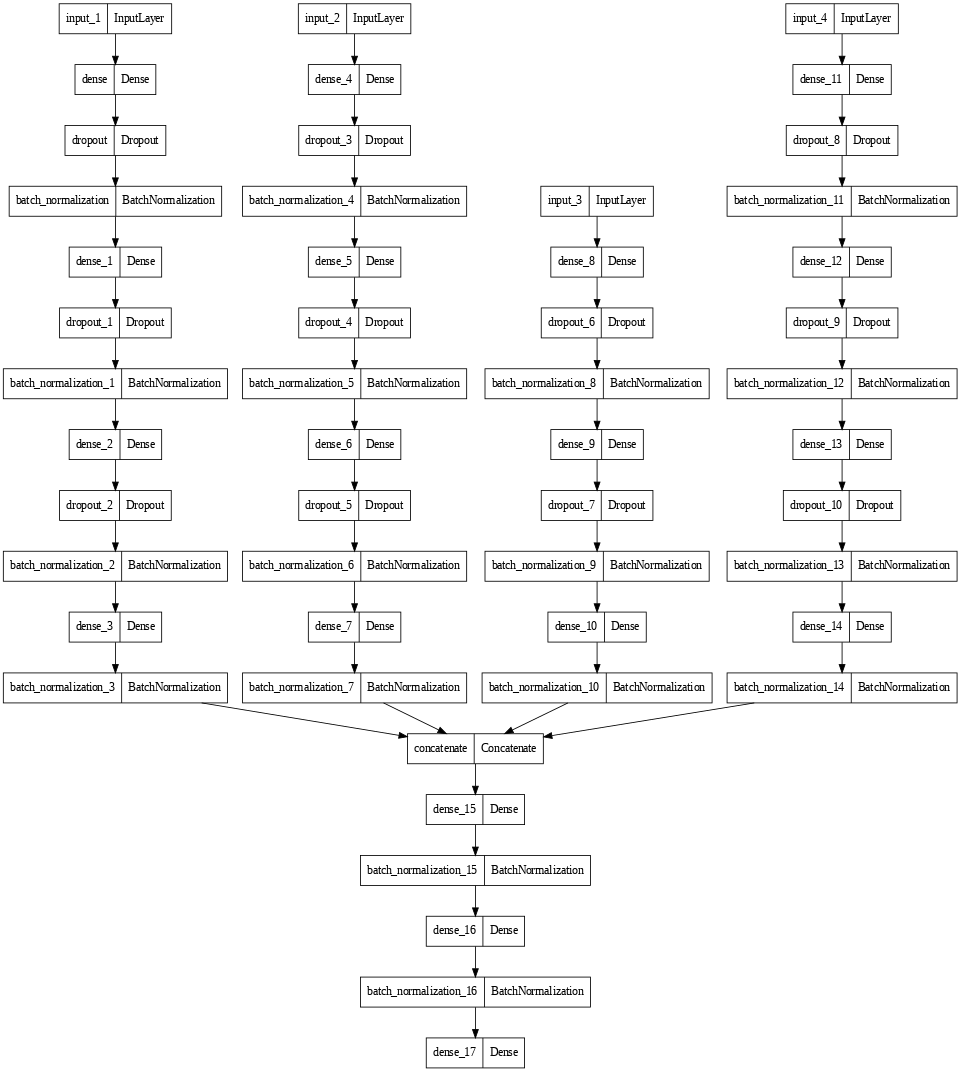

In [120]:
utils.plot_model(model_final, dpi=60)

In [121]:
model_final.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 500)]        0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 1000)]       0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, 500)]        0           []                               
                                                                                                  
 dense (Dense)                  (None, 1000)         501000      ['input_1[0][0]']                
                                                                                              

Epoch 1/30
80/80 [==============================] - 57s 564ms/step - loss: 0.6000 - accuracy: 0.7597 - val_loss: 1.1653 - val_accuracy: 0.3223
Epoch 2/30
80/80 [==============================] - 46s 580ms/step - loss: 0.3465 - accuracy: 0.9069 - val_loss: 1.2327 - val_accuracy: 0.3223
Epoch 3/30
80/80 [==============================] - 45s 559ms/step - loss: 0.2956 - accuracy: 0.9278 - val_loss: 1.2487 - val_accuracy: 0.3223
Epoch 4/30
80/80 [==============================] - 44s 554ms/step - loss: 0.2718 - accuracy: 0.9321 - val_loss: 1.1693 - val_accuracy: 0.3223
Epoch 5/30
80/80 [==============================] - 44s 553ms/step - loss: 0.2531 - accuracy: 0.9448 - val_loss: 0.9968 - val_accuracy: 0.3517
Epoch 6/30
80/80 [==============================] - 44s 548ms/step - loss: 0.2395 - accuracy: 0.9483 - val_loss: 0.7100 - val_accuracy: 0.6483
Epoch 7/30
80/80 [==============================] - 44s 553ms/step - loss: 0.2276 - accuracy: 0.9491 - val_loss: 0.4433 - val_accuracy: 0.9190

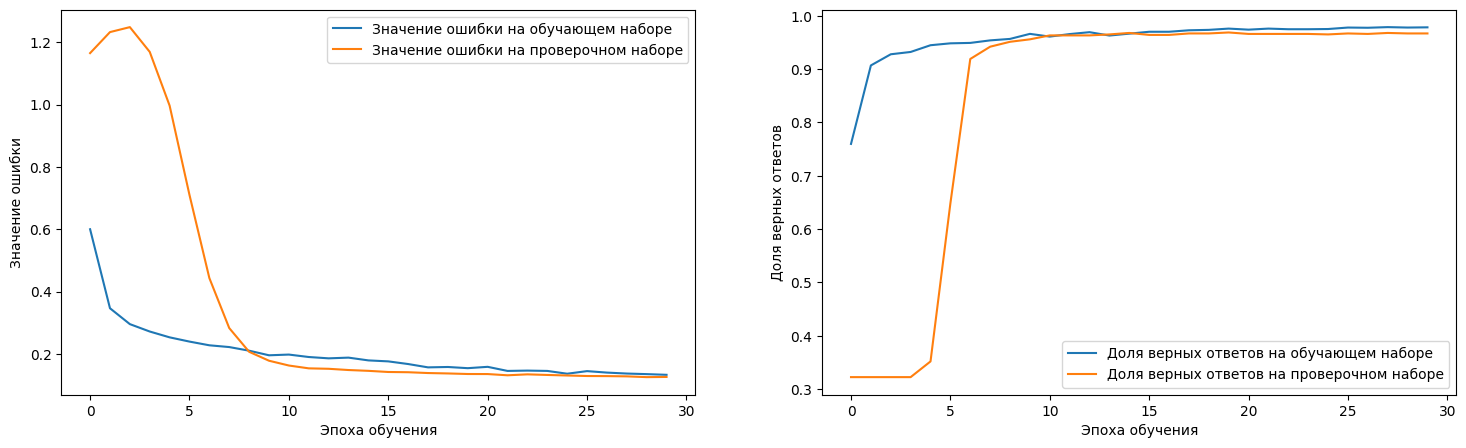

In [122]:
# Обучение модели
model_final.compile(optimizer=Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])
history = model_final.fit([x_train_harm, x_train_Diag, x_train_gz, x_train_recom], 
                           y_train,
                           shuffle=True,
                           batch_size=32, 
                           epochs=30, 
                           validation_split=0.3,
                           verbose=1)

# Создание полотна для рисунка
plt.figure(1, figsize=(18, 5))

# Задание первой (левой) области для построения графиков
plt.subplot(1, 2, 1)
# Отрисовка графиков 'loss' и 'val_loss' из значений словаря store_learning.history
plt.plot(history.history['loss'], 
         label='Значение ошибки на обучающем наборе')
plt.plot(history.history['val_loss'], 
         label='Значение ошибки на проверочном наборе')
# Задание подписей осей 
plt.xlabel('Эпоха обучения')
plt.ylabel('Значение ошибки')
plt.legend()

# Задание второй (правой) области для построения графиков
plt.subplot(1, 2, 2) 
# Отрисовка графиков 'accuracy' и 'val_accuracy' из значений словаря store_learning.history
plt.plot(history.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')
# Задание подписей осей 
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()

# Фиксация графиков и рисование всей картинки
plt.show()

In [123]:
# Сохраним модель на диске
model_final.save( 'model_7th.h5' )

In [125]:
files.download(filename='model_7th.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [124]:
# Загрузка модели
model_download = tf.keras.models.load_model('model_7th.h5')

114/114 [==============================] - 11s 91ms/step


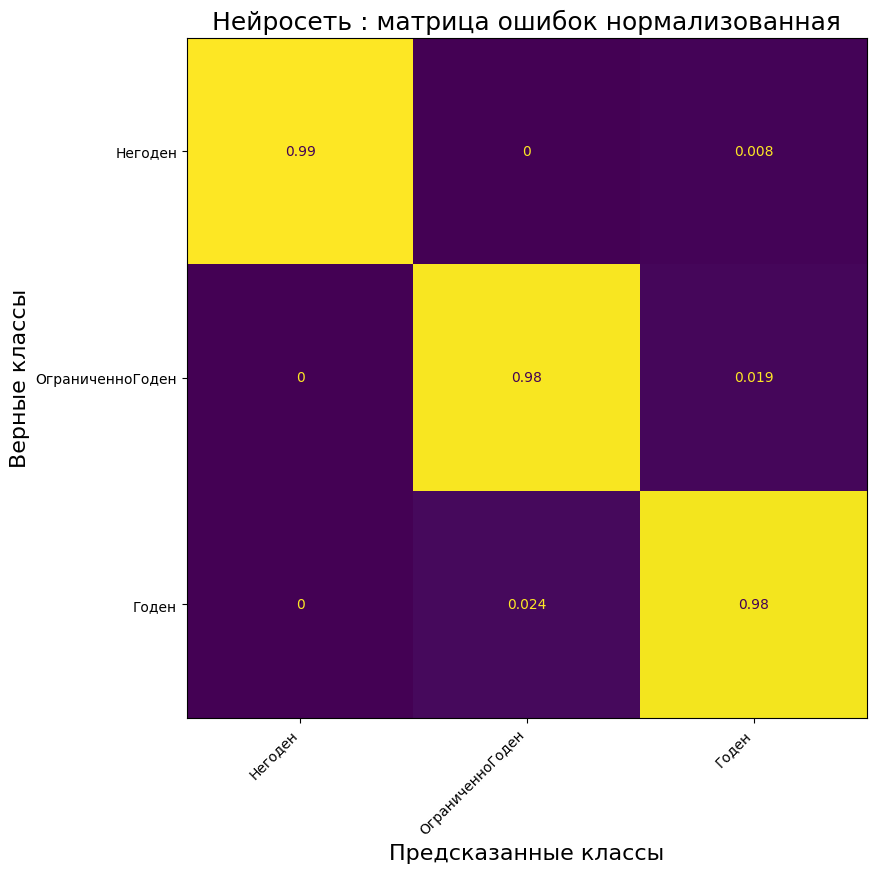

----------------------------------------------------------------------------------------------------
Нейросеть: 

Средняя точность распознавания:  98%


In [126]:
# Запуск предсказания и визуализация
eval_model(model_download, [x_train_harm, x_train_Diag, x_train_gz, x_train_recom], 
                           y_train, class_labels = CLASS_DICT)

In [128]:
# Пример предсказания

# Получаем список номеров строк (индексов) с соответсвующими классами           
indexes_0 = dffix9.loc[dffix9['ЗаключениеМК'] == 'Негоден'].index.tolist()
indexes_1 = dffix9.loc[dffix9['ЗаключениеМК'] == 'ОграниченноГоден'].index.tolist()
indexes_2 = dffix9.loc[dffix9['ЗаключениеМК'] == 'Годен'].index.tolist()

# Случайно выбираем по одному представителю из класса
n_0 = random.choice(indexes_0)
n_1 = random.choice(indexes_1)
n_2 = random.choice(indexes_2)

# Предсказание по сформированной выборке Вредности и Диагноза
y_pred = model_download.predict([x_train_harm, x_train_Diag, x_train_gz, x_train_recom])

# Перевод полученного вектора в номера классов (0,1,2)
y = np.argmax(y_pred, axis=-1)

# Сформируем таблицу с выводом реальных значений и предсказания
df_pred = pd.DataFrame({'Реальное заключение': ['Негоден', 'ОграниченноГоден', 'Годен'],
                   'Реальный вектор': [y_train[n_0], y_train[n_1], y_train[n_2]],
                   'Реальный класс': [y_data[n_0], y_data[n_1], y_data[n_2]],
                   'Предсказанный вектор': [y_pred[n_0], y_pred[n_1], y_pred[n_2]],
                   'Предсказанный класс': [y[n_0], y[n_1], y[n_2]],
                   'ГЗ': [dffix9.iloc[n_0][1], dffix9.iloc[n_1][1], dffix9.iloc[n_2][1]],
                   'Вредность': [dffix9.iloc[n_0][2], dffix9.iloc[n_1][2], dffix9.iloc[n_2][2]],
                   'Диагнозы': [dffix9.iloc[n_0][3], dffix9.iloc[n_1][3], dffix9.iloc[n_2][3]],
                   'Рекомендации': [dffix9.iloc[n_0][4], dffix9.iloc[n_1][4], dffix9.iloc[n_2][4]]
                   })

df_pred['Предсказанный вектор'] = df_pred['Предсказанный вектор'].apply(format_vector)

df_pred

114/114 [==============================] - 8s 70ms/step


,Реальное заключение,Реальный вектор,Реальный класс,Предсказанный вектор,Предсказанный класс,ГЗ,Вредность,Диагнозы,Рекомендации
0,Негоден,"[0.0, 0.0, 1.0]",2,"[0.0, 0.0, 1.0]",2,,4.3.2,Высокая или осложненная близорукость выше 80 Д,
1,ОграниченноГоден,"[0.0, 1.0, 0.0]",1,"[0.0, 0.8, 0.2]",1,II,4.5,"Общий медицинский осмотр,Гиперметропия,Общий м...",Использование средств оптической коррекции зрения
2,Годен,"[1.0, 0.0, 0.0]",0,"[1.0, 0.0, 0.0]",0,II,23,"Тремор неуточненный,Общий медицинский осмотр,О...",


In [129]:
# Сформируем отдельную функцию, которая по передаваемой исходной таблицы создает сжатую
def getclin(df_in):
  # Получаем на вход некую таблицу данных вида аналогичного первоначально предоставленной
  # Подготовка таблицы данных
  # Убираем полностью пустые строки
  df_in = df_in.dropna(axis=1, how='all')

  # Убираем строки в которых отстутствует одно из встреченных заключений Профпатолога (ПП)
  df_in = df_in[df_in['ЗаключениеМК'].isin(['Годен',
                                      'ГоденСКоррекциейЗрения',
                                      'ВременноНегоден',
                                      'НуждаетсяВДообследованииИЛечении',
                                      'ОграниченноГоден',
                                      'ГоденБезРаботНаВысотах'])]

  # Приводим к 3-м классам (Годен, Негоден, ОграниченноГоден)
  df_in.loc[df_in['ЗаключениеМК'] == 'ВременноНегоден', 'ЗаключениеМК'] = 'Негоден'
  df_in.loc[df_in['ЗаключениеМК'] == 'НуждаетсяВДообследованииИЛечении', 'ЗаключениеМК'] = 'Негоден'
  df_in.loc[df_in['ЗаключениеМК'] == 'ГоденСКоррекциейЗрения', 'ЗаключениеМК'] = 'ОграниченноГоден'
  df_in.loc[df_in['ЗаключениеМК'] == 'ГоденБезРаботНаВысотах', 'ЗаключениеМК'] = 'ОграниченноГоден'

  # Для удобства обращения к столбцу, переименуем его в название из одного слова
  df_in.rename(columns = {'Вредные Факторы':'Вредность'}, inplace = True )
  df_in.rename(columns = {'Диспансерная Группа':'ГруппаЗдоровья'}, inplace = True )

  # Оставляем только значащие для нас колонки: Заключение ПП, Вредность и Диагнозы узких специалистов в текстовом представлении
  df_in = df_in[['ЗаключениеМК',
  'ГруппаЗдоровья',
  'Вредность',
  'Психиатрия Наркология1 Диагноз Представление1',
  'Офтальмология1_ДиагнозПредставление1',
  'Оториноларингология1_ДиагнозПредставление1',
  'Гинекология1_ДиагнозПредставление1',
  'Стоматология1_ДиагнозПредставление1',
  'Дерматовенерология1_ДиагнозПредставление1',
  'Рентгенология1_ДиагнозПредставление1',
  'Неврология1_ДиагнозПредставление1',
  'УЗИДиагностика1_Заключение_ЗначениеПредставление',
  'Терапия1_ДиагнозПредставление1',
  'Хирургия1_ДиагнозПредставление1',
  'Офтальмология1_ДиагнозПредставление2',
  'Терапия2_ДиагнозПредставление1',

  'ЛабораторныеИсследования1_ХР_Рекомендация1Представление',
  'Рентгенология1_Заключение_ЗначениеПредставление',
  'ПсихиатрияНаркология1_ХР_Рекомендация1Представление',
  'Офтальмология1_ХР_Рекомендация1Представление',
  'Офтальмология1_ХР_Рекомендация2Представление',
  'Оториноларингология1_ХР_Рекомендация1Представление',
  'Гинекология1_ХР_Рекомендация1Представление',
  'Гинекология1_ХР_Рекомендация2Представление',
  'ФункциональнаяДиагностика1_ХР_Рекомендация1Представление',
  'Стоматология2_ХР_Рекомендация1Представление',
  'Терапия1_ХР_Рекомендация1Представление',
  'Терапия1_ХР_Рекомендация2Представление',
  'Дерматовенерология1_ХР_Рекомендация1Представление',
  'Дерматовенерология1_ХР_Рекомендация2Представление',
  'Неврология1_ХР_Рекомендация1Представление',
  'Хирургия1_ХР_Рекомендация1Представление',
  'Терапия2_ХР_Рекомендация1Представление',
  'Терапия2_ХР_Рекомендация2Представление'
  ]]

  # Заменяем отсутсвтующие записи узких специалистов в пробелы
  df_in=df_in.fillna('')

  # Обобщенный диагноз - собирем диагнозы узких специалистов в одну строку через запятую
  df_in['Свод_Диагноз'] = (df_in['Психиатрия Наркология1 Диагноз Представление1'].map(str) + ','
  + df_in['Офтальмология1_ДиагнозПредставление1'].map(str)+ ','
  + df_in['Оториноларингология1_ДиагнозПредставление1'].map(str)+ ','
  + df_in['Гинекология1_ДиагнозПредставление1'].map(str)+ ','
  + df_in['Стоматология1_ДиагнозПредставление1'].map(str)+ ','
  + df_in['Дерматовенерология1_ДиагнозПредставление1'].map(str)+ ','
  + df_in['Рентгенология1_ДиагнозПредставление1'].map(str)+ ','
  + df_in['Неврология1_ДиагнозПредставление1'].map(str)+ ','
  + df_in['УЗИДиагностика1_Заключение_ЗначениеПредставление'].map(str)+ ','
  + df_in['Терапия1_ДиагнозПредставление1'].map(str)+ ','
  + df_in['Хирургия1_ДиагнозПредставление1'].map(str)+ ','
  + df_in['Офтальмология1_ДиагнозПредставление2'].map(str)+ ','
  + df_in['Терапия2_ДиагнозПредставление1'].map(str))



  # Обобщенная рекомендация
  df_in['Рекомендации'] = (df_in['ЛабораторныеИсследования1_ХР_Рекомендация1Представление'].map(str) + ','
  + df_in['Рентгенология1_Заключение_ЗначениеПредставление'].map(str) + ','
  + df_in['ПсихиатрияНаркология1_ХР_Рекомендация1Представление'].map(str)+ ','
  + df_in['Офтальмология1_ХР_Рекомендация1Представление'].map(str)+ ','
  + df_in['Офтальмология1_ХР_Рекомендация2Представление'].map(str)+ ','
  + df_in['Оториноларингология1_ХР_Рекомендация1Представление'].map(str)+ ','
  + df_in['Гинекология1_ХР_Рекомендация1Представление'].map(str)+ ','
  + df_in['Гинекология1_ХР_Рекомендация2Представление'].map(str)+ ','
  + df_in['ФункциональнаяДиагностика1_ХР_Рекомендация1Представление'].map(str)+ ','
  + df_in['Стоматология2_ХР_Рекомендация1Представление'].map(str)+ ','
  + df_in['Терапия1_ХР_Рекомендация1Представление'].map(str)+ ','
  + df_in['Терапия1_ХР_Рекомендация2Представление'].map(str)+ ','
  + df_in['Дерматовенерология1_ХР_Рекомендация1Представление'].map(str)+ ','
  + df_in['Дерматовенерология1_ХР_Рекомендация2Представление'].map(str)+ ','
  + df_in['Неврология1_ХР_Рекомендация1Представление'].map(str)+ ','
  + df_in['Хирургия1_ХР_Рекомендация1Представление'].map(str)+ ','
  + df_in['Терапия2_ХР_Рекомендация1Представление'].map(str)+ ','
  + df_in['Терапия2_ХР_Рекомендация2Представление'].map(str))


  # Упрвостим таблицу данных до 5 столбцов
  df_in1 = df_in[['ЗаключениеМК',
                 'ГруппаЗдоровья',
                 'Вредность',
                 'Свод_Диагноз',
                 'Рекомендации']]

  # Получаем новую таблицу данных
  df_res1=diag_adv(df_in1)
  df_res2=recom_adv(df_res1)

  # Удаляем строки с отстуствующими записями всех узких специалистов                    
  df_res3 = df_res2[df_res2['Диагнозы']!='']

  # обновляем номера индексов
  df_res=df_res3.reset_index(drop=True)
  return df_res

In [138]:
# Функция расширения таблицы данных
def gen_df (df0, df1, N_ag, N_lim):
  # Создадим список противопоказаний
  list_against = df1['Свод_Диагноз'].tolist()

  # И очистим его ранее подготовленной функцией
  clearlist=[]
  for A in list_against:
    clearlist.append(clean_string(A))
  
  # Поместим в новую колонку очищенные строки из полученного списка
  df1['Диагнозы'] = True
  df1['Диагнозы'] = clearlist

  # Получаем новую таблицу данных
  df11=df1[['ЗаключениеМК',
                        'Вредность',
                        'Диагнозы']]

  # Создадим список вредностей из добавленной таблицы данных по Приказу 29н
  listharm1 = df11['Вредность'].unique().tolist()

  # Из списка вредностей составим словарь
  dict1 = dict.fromkeys(listharm1)
  for A in listharm1:
    df12 = df11[df11['Вредность']==A]
    listdiag = df12['Диагнозы'].unique().tolist()
    dict1[A]=listdiag

  # Создаем новую таблицу данных с добавлением 1100 записей негоден
  df13 = gen_profstop (N_ag, dict1, listharm1, df0)
  
  # Создадим выборку имеющихся записей класса ОграниченноГоден
  df14 = df0[df0['ЗаключениеМК'].isin(['ОграниченноГоден'])]
  df14 = df14.reset_index(drop=True)

  # Создадим список вредностей соответствующих классу ОграниченноГоден
  listharm2 = df14['Вредность'].unique().tolist()
  
  # И словарь с ключами из этого списка
  dict2 = dict.fromkeys(listharm2)

  for A in listharm2:
    df15 = df_limited[df14['Вредность']==A]
    list_of_diag = df15['Диагнозы'].unique().tolist()
    list_of_gz = df15['ГруппаЗдоровья'].unique().tolist()
    list_of_recom = df15['Рекомендации'].unique().tolist()
    list_comb = [list_of_gz, list_of_diag, list_of_recom]
    dict2[A]=list_comb

  # Создадим новый словарь с почищенными и разделенными записями по ранне определенной функции
  new_dict = clean_dict(dict2)
  
  # Получим список ключей нового словаря - единичных записей вредности
  listharm3 = []
  for key in new_dict:
    listharm3.append(key)

  df2 = gen_proflimited (N_lim, new_dict, listharm3, df13)
  print (df2.shape)
  return df2


In [130]:
# Функция преобразования данных из таблицы во входные данные для модели

def getXdata (df_res):
  # Извлечение текстов о вредности для выборки
  harm_text = extract_harm_text(df_res) 

  tokenizer_harm.fit_on_texts(harm_text)
  items_harm = list(tokenizer_harm.word_index.items())

  # Преобразование текстов в последовательность индексов согласно частотному словарю
  harm_seq = tokenizer_harm.texts_to_sequences(harm_text)

  # Преобразование последовательностей индексов в bag of words
  x_harm = tokenizer_harm.sequences_to_matrix(harm_seq)

  # Извлечение текстов о сводном диагнозе для выборки
  Diag_text = extract_Diag_text(df_res) 

  tokenizer_Diag.fit_on_texts(Diag_text)
  items_Diag = list(tokenizer_Diag.word_index.items())

  # Преобразование текстов в последовательность индексов согласно частотному словарю
  Diag_seq = tokenizer_Diag.texts_to_sequences(Diag_text)

  # Преобразование последовательностей индексов в bag of words
  x_diag = tokenizer_Diag.sequences_to_matrix(Diag_seq)


  # Извлечение текстов о рекомендациях для выборки
  recom_text = extract_recom_text(df_res) 

  tokenizer_recom.fit_on_texts(recom_text)
  items_recom = list(tokenizer_recom.word_index.items())

  # Преобразование текстов в последовательность индексов согласно частотному словарю
  recom_seq = tokenizer_recom.texts_to_sequences(recom_text)

  # Преобразование последовательностей индексов в bag of words
  x_recom = tokenizer_recom.sequences_to_matrix(recom_seq)

   

  return x_harm, x_diag, x_recom


In [131]:
# Формирование выборки из тестовой таблицы
x_test_harm, x_test_diag, x_test_recom = getXdata (dffix9[:100])

x_test_gz = extract_gz(dffix9[:100])

y_data_test, y_vect_test = Y_to_OHE(dffix9[:100])

y_vec_list = list(y_vect_test)
y_data_list = list(y_data_test)

In [132]:
# Предсказание по сформированной выборке Вредности и Диагноза
y_pred = model_download.predict([x_test_harm, x_test_diag, x_test_gz, x_test_recom])

y_pred_list = list(y_pred)

# Перевод полученного вектора в номера классов (0,1,2)
y = np.argmax(y_pred, axis=-1)

y_list = list (y)

4/4 [==============================] - 0s 81ms/step


In [133]:
# Создадим списки входных данных
dftest=dffix9.iloc[:100]
x_harm_list = list(dftest['Вредность'])
x_diag_list = list(dftest['Диагнозы'])
x_recom_list = list(dftest['Рекомендации'])
x_gz_list = list(dftest['ГруппаЗдоровья'])

In [134]:
# Сформируем таблицу с выводом реальных значений и предсказания
df_pred = pd.DataFrame({'РеалВектор': y_vec_list,
                   'РеалКласс': y_data_list,
                   'ПредВектор': y_pred_list,
                   'ПредКласс': y_list,
                   'ГруппаЗдоровья': x_gz_list,
                   'Вредный фактор': x_harm_list,
                   'Диагнозы': x_diag_list,
                   'Рекомендации': x_recom_list
                   })
# Обработка вывода вектора
df_pred['ПредВектор'] = df_pred['ПредВектор'].apply(format_vector)

df_pred

,РеалВектор,РеалКласс,ПредВектор,ПредКласс,ГруппаЗдоровья,Вредный фактор,Диагнозы,Рекомендации
0,"[0.0, 0.0, 1.0]",2,"[0.0, 0.2, 0.8]",2,IIIа,11.1,"Общий медицинский осмотр,Общий медицинский осм...",
1,"[0.0, 0.0, 1.0]",2,"[0.0, 0.0, 0.9]",2,I,"6.1,9,6.1,9","Общий медицинский осмотр,Общий медицинский осм...",
2,"[0.0, 0.0, 1.0]",2,"[0.0, 0.0, 1.0]",2,I,"4.4,4.5,6.1","Общий медицинский осмотр,Общий медицинский осм...",
3,"[0.0, 0.0, 1.0]",2,"[0.0, 0.0, 1.0]",2,I,"11,18","Общий медицинский осмотр,Общий медицинский осм...",
4,"[0.0, 1.0, 0.0]",1,"[0.0, 0.9, 0.0]",1,II,8,"Общий медицинский осмотр,Гиперметропия,Общий м...",Допуск с ношением средств оптической коррекции...
...,...,...,...,...,...,...,...,...
95,"[0.0, 0.0, 1.0]",2,"[0.0, 0.3, 0.7]",2,IIIа,"4.7,4.8,5.1","Общий медицинский осмотр,Миопия,Общий медицинс...",Использование средств оптической коррекции зрения
96,"[1.0, 0.0, 0.0]",0,"[1.0, 0.0, 0.0]",0,,17,Хронические заболевания бронхолегочной системы...,
97,"[1.0, 0.0, 0.0]",0,"[1.0, 0.0, 0.0]",0,,14,Варикозная болезнь и рецидивирующий тромбофлеб...,
98,"[0.0, 1.0, 0.0]",1,"[0.0, 0.9, 0.1]",1,II,1.29.1,"Общий медицинский осмотр,Миопия,Общий медицинс...",Использование средств оптической коррекции зрения


4/4 [==============================] - 0s 57ms/step


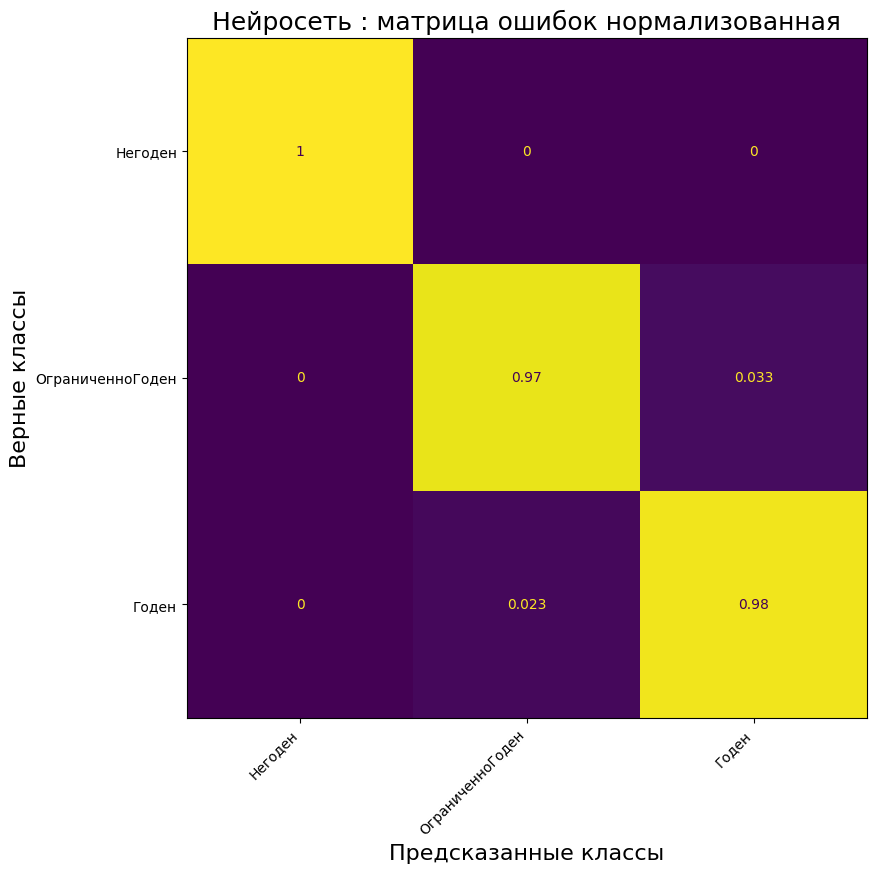

----------------------------------------------------------------------------------------------------
Нейросеть: 

Средняя точность распознавания:  98%


In [135]:
#  Запуск предсказания и визуализация на тестовой выборке
eval_model(model_download, [x_test_harm, x_test_diag, x_test_gz, x_test_recom], 
                           y_vect_test, class_labels = CLASS_DICT)

In [136]:
df_clin = getclin(df)

In [139]:
df_gen = gen_df (df_clin, df_add, 1100, 1200)

(3720, 5)
